<center>Заметка 6.б Поиск сложных объектов</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

/opt/conda/envs/myTF/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Составной объект</h3>

Покажем как используя метод поиска по оразцу искать составной объект,
т.е. объект составленный из более приметивных объектов. (Строить отдельный шаблон для составного объекта и затем его искать вычислительно дорого)

<b>Треугольник</b>

Научимся рисовать треугольник на изображении. Это будет одной и частей составного объекта.

In [2]:
sz = 30

In [3]:
def draw_triag( triag, sz, offset = (0,0), col = 1 ):
    nds = np.array([[ (0, sz-1), (sz-1, sz-1), (sz//2, 0) ]], np.int32)
    nds = nds + offset
    cv.fillPoly( triag, nds, col, 1);

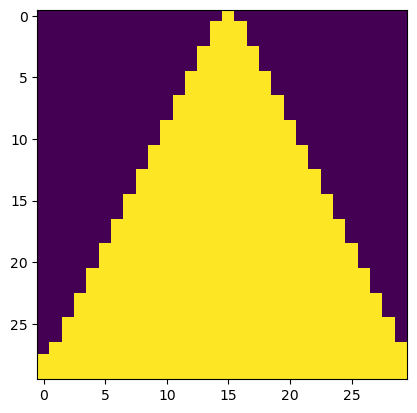

In [4]:
# Проверим отрисовку треугольника
triag = np.zeros((sz, sz), "uint8")
draw_triag( triag, 30 )
plt.imshow( triag );

<b>Квадрат</b>

По аналогии с квадратом.

In [5]:
def draw_square( square, sz, offset = (0,0), col = 1 ):
    nds = np.array([[ (0, 0), (0, sz-1), (sz-1, sz-1), (sz-1, 0) ]], np.int32)
    nds = nds + offset
    cv.fillPoly( square, nds, col, 1);

In [6]:
square = np.zeros((sz, sz), "uint8")
draw_square( square, 30 )

In [7]:
np.max( square), np.min( square)

(1, 1)

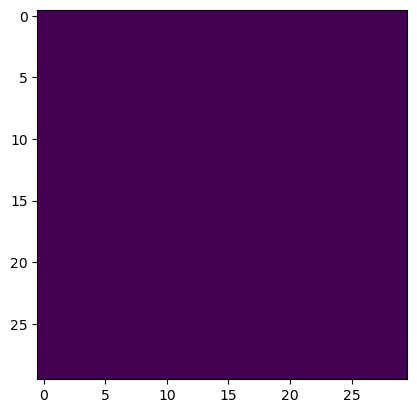

In [8]:
# почему ничего не отобразится?
plt.imshow( square ); # квадрат занимает всё изображение

In [9]:
np.unique( square )

array([1], dtype=uint8)

<b>Составной объект</b>

Теперь покажем как выглядит сам составной объект.

In [10]:
img = np.zeros((60, 30), "uint8")

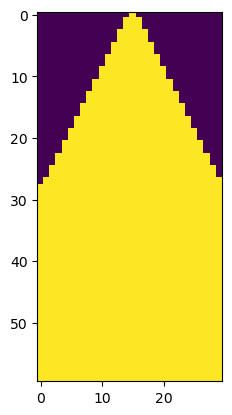

In [11]:
draw_triag( img, 30, (0,0) )
draw_square( img, 30, (0,30) )
plt.imshow( img );

<b>Ищем на картинке</b>

Сформируем изображение со составным объектом и его частями.

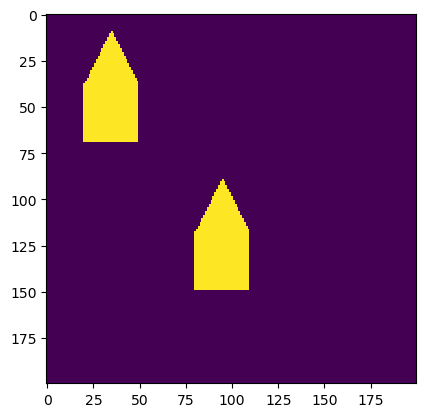

In [12]:
img = np.zeros((200, 200), "uint8")

draw_triag( img, 30, (20,10) )
draw_square( img, 30, (20,40) )

draw_triag( img, 30, (80,90) )
draw_square( img, 30, (80,120) )

plt.imshow( img, interpolation = 'none' );

Добавим к картинке случайные части от составного объекта: треугольники и квадраты.

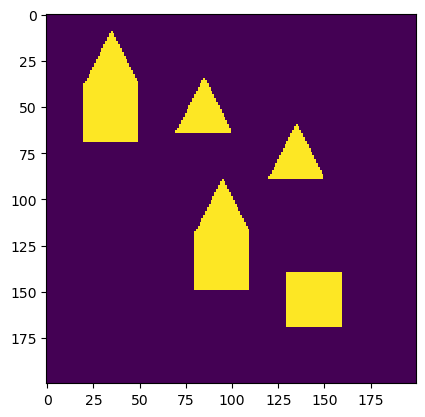

In [13]:
draw_triag( img, 30, (70,35) )
draw_triag( img, 30, (120,60) )
draw_square( img, 30, (130,140) )

plt.imshow( img, interpolation = 'none' );

Добавим совсем мусор (круги).

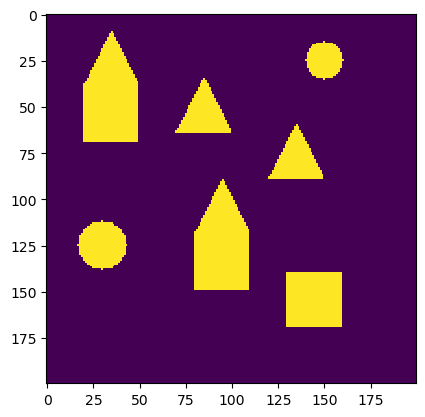

In [14]:
cv.circle(img, (150, 25), 10, 1, -1)
cv.circle(img, (30, 125), 13, 1, -1)
plt.imshow( img, interpolation = 'none' );

Как найти составной объект?

<b>Способ 1: целый объект</b>

Делается по аналогии с буквой.

<b>Способ 2: по частям</b>

Сначала найдем треугольники. (аналогично тому, что было в первой части занятия)

In [15]:
cc = cv.matchTemplate(img, triag, cv.TM_CCORR_NORMED)
cc.shape

(171, 171)

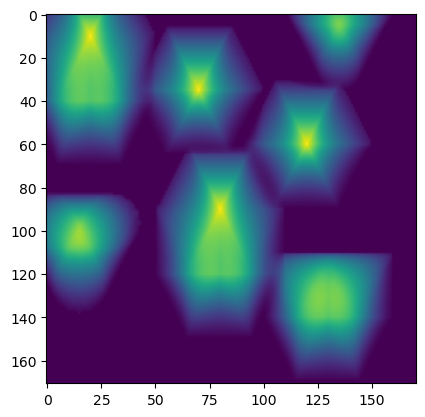

In [16]:
plt.imshow( cc );

In [17]:
w = (cc > 0.99).astype( 'uint8' )

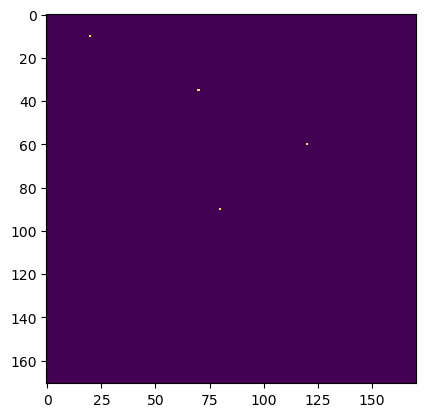

In [18]:
plt.imshow( w, interpolation = 'none' ); #отобразим точки, в которых находился треугольник

In [19]:
retval, labels, geomStats, centroids = cv.connectedComponentsWithStats( w )

In [20]:
centroids = centroids[1:] # Убираем центр фона.
centroids.shape

(4, 2)

Отметим найденные треугольники на исходном синтезированом изображении. Убедимся, что все треугольники найдены

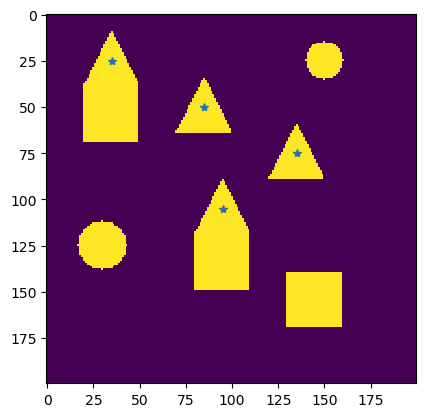

In [21]:
plt.imshow( img, interpolation = 'none' )
plt.plot( centroids[:,0]+15, centroids[:,1]+15, "*" ); # 15 учитываем размер шаблона.

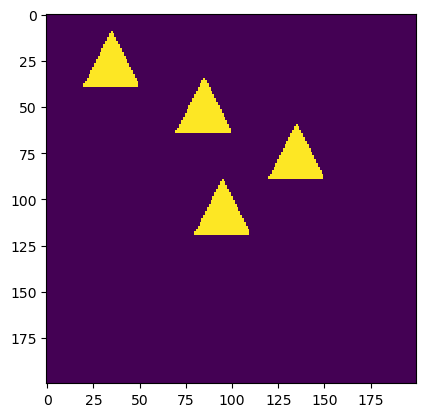

In [22]:
# Выводим что находим, треугольники
fndT = np.zeros((200, 200), "uint8")
for cntr in centroids:
    draw_triag( fndT, 30, np.int32(cntr[::]), 2 )
plt.imshow( fndT, interpolation = 'none'  );

Сравниваем исходное изображение с найдеными реугольниками.
Видим, что совпадение очень хорошее.

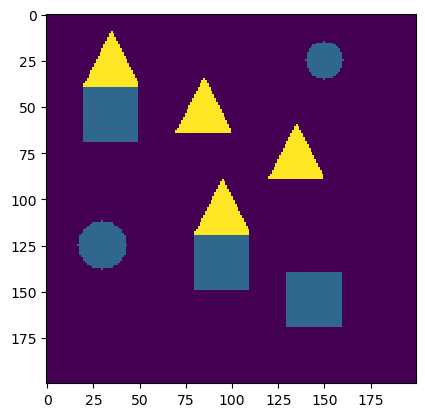

In [23]:
plt.imshow( fndT + img, interpolation = 'none' );

Далее по аналогии с квадратами.

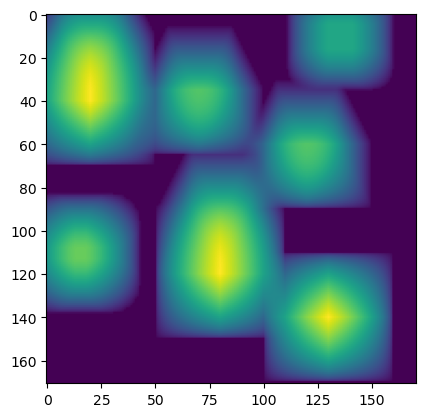

In [24]:
cc = cv.matchTemplate(img, square, cv.TM_CCORR_NORMED)
plt.imshow( cc );

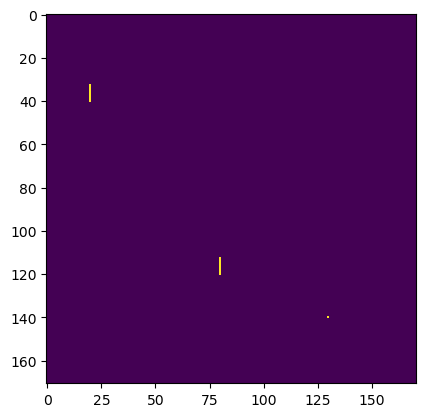

In [25]:
w = (cc > 0.99).astype( 'uint8' )
plt.imshow( w, interpolation = 'none' );

Заметим, что на рисунке отображены не только точки, но и вертикальные отрезки, которые соответсвуют составному изображению. Это происходит, потому что в составном объекте к квадрату сверху прикреплён треугольник 

In [26]:
retval, labels, geomStats, centroids = cv.connectedComponentsWithStats( w )
centroids = centroids[1:] # Убираем центр фона.
centroids.shape

(3, 2)

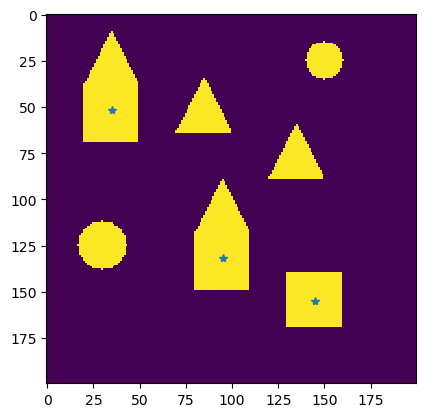

In [27]:
plt.imshow( img, interpolation = 'none' )
plt.plot( centroids[:,0]+15, centroids[:,1]+15, "*" );

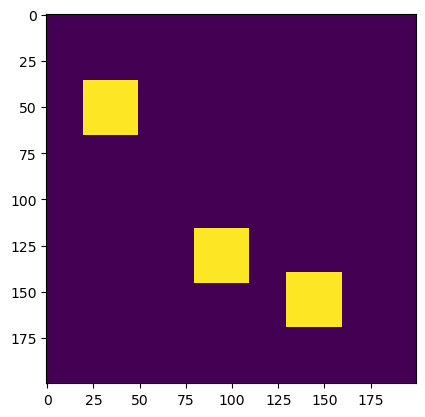

In [28]:
# Выводим что находим, квадраты
fndS = np.zeros((200, 200), "uint8")
for cntr in centroids:
    draw_square( fndS, 30, np.int32(cntr[::]), 2 )
plt.imshow( fndS, interpolation = 'none' );

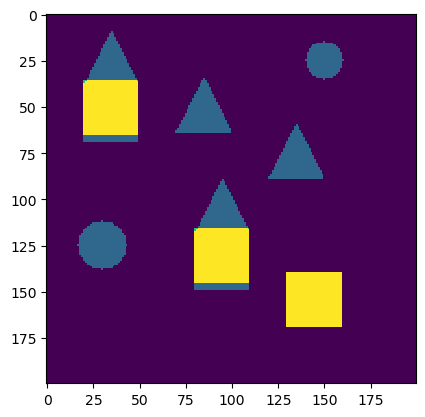

In [29]:
plt.imshow( fndS + img, interpolation = 'none' ); #выводим квадраты поверх исходного изображения

Квадраты смещены, т.к. функция поиска связанных компонент взяла у полученных ранее отрезков середину.

Теперь перейдем к поиску составного объекта на основе найденных частей. Если  треугольник и квадрат налезают друг на друга - то это составной объект, иначе - отдельный квадрат / треугольник

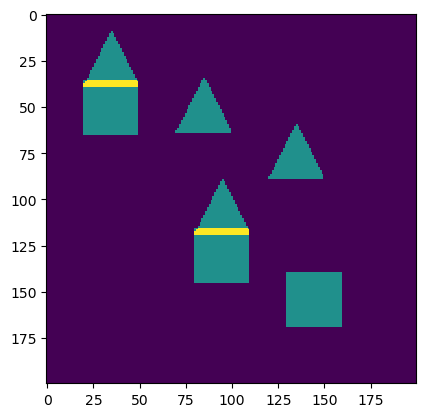

In [30]:
plt.imshow( fndT + fndS, interpolation = 'none' );

Ищим в составном изображении наложение, т.е. значение 4.

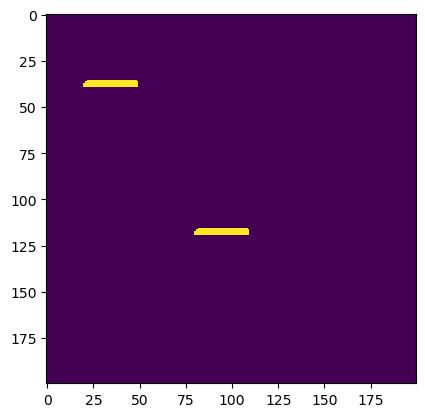

In [31]:
comb = ((fndT + fndS) == 4)
plt.imshow( comb, interpolation = 'none' );

In [32]:
comb = (comb!=0).astype("uint8")

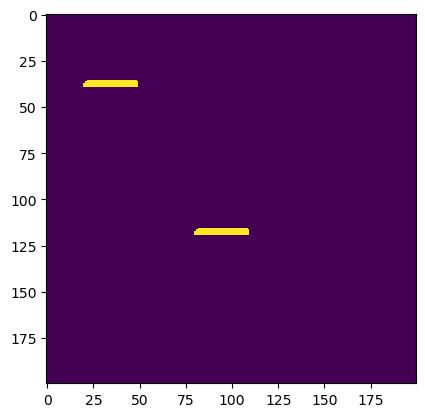

In [33]:
plt.imshow( comb, interpolation = 'none' );

In [34]:
retval, labels, geomStats, centroids = cv.connectedComponentsWithStats( comb )
centroids = centroids[1:] # Убираем центр фона.
centroids.shape

(2, 2)

Отметим найденный сотавной объект на исходном изображении.

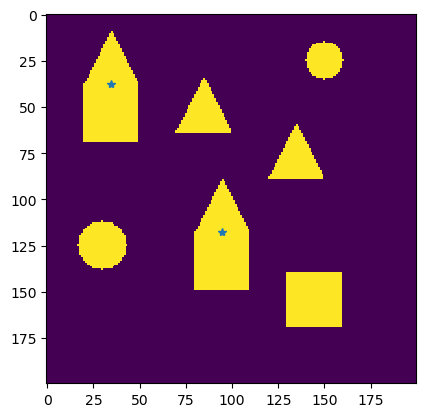

In [35]:
plt.imshow( img, interpolation = 'none' )
plt.plot( centroids[:,0], centroids[:,1], "*" );

Нашли два составных объекта.

<h3>Цветные изображения</h3>

Покажем применимость метода поиска по шаблону на цветных изображениях. Покажем в чем особенность.

Сформируем цветное изображение с цветными буквами.

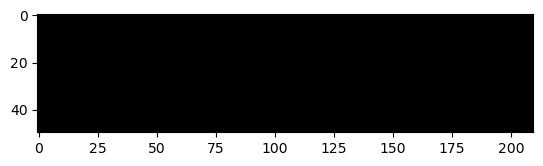

In [36]:
txt_rgb = np.zeros( (50, 210,3), np.uint8 )
plt.imshow( txt_rgb );

In [37]:
font                   = cv.FONT_HERSHEY_SIMPLEX
fontScale              = 1
lineType               = cv.LINE_4

In [38]:
tmpl = np.zeros((21, 20), "uint8");

In [39]:
cv.putText(tmpl,'o', 
    (0,17), 
    font, 
    fontScale,
    200,
    lineType);

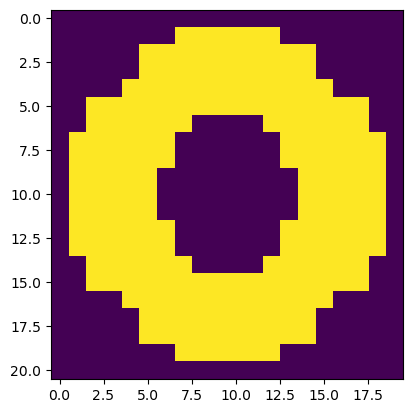

In [40]:
plt.imshow( tmpl );

In [41]:
cv.putText( txt_rgb, 'o', 
    (10, 20), 
    font, fontScale,
    (200,0,0),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20, 20), 
    font, fontScale,
    (0,200,0),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20, 20), 
    font, fontScale,
    (200,0,0),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20, 20), 
    font, fontScale,
    (200,200,0),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20, 20), 
    font, fontScale,
    (200,0,200),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20+20, 20), 
    font, fontScale,
    (0,200,200),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20+20+20, 20), 
    font, fontScale,
    (200,200,200),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20+20+20+20, 20), 
    font, fontScale,
    (0,0,200),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20+20+20+20+20, 20), 
    font, fontScale,
    (100,0,0),
    lineType);

cv.putText( txt_rgb, 'o', 
    (10+20+20+20+20+20+20+20+20+20, 20), 
    font, fontScale,
    (250,0,0),
    lineType);

Поиск буквы О будет осуществлен на цветном изображении с цветными буквами о. Хотим найти букву "о" определённого цвета

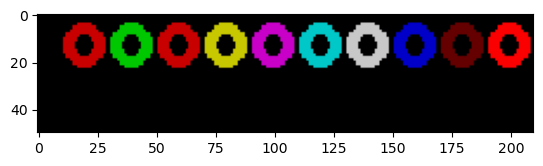

In [42]:
plt.imshow( txt_rgb );

Возьмем исходный черно белый шаблон буквы о...

(21, 20)

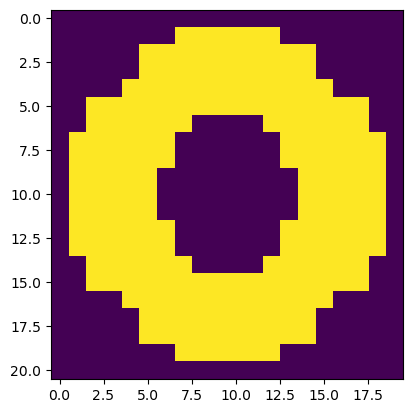

In [43]:
plt.imshow( tmpl )
tmpl.shape

и для начала попробуем применить его как есть к цветному изображению.

In [44]:
cc = cv.matchTemplate(txt_rgb, tmpl, cv.TM_CCORR_NORMED )
plt.imshow( cc )# Будет ошибка, т.к функция matchTemplate требует, чтобы шаблон по каналам совпадал с изображением

error: OpenCV(4.6.0) /opt/conda/conda-bld/opencv-suite_1664548337286/work/modules/imgproc/src/templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


Нужно сделать у темплайта такое же количество цветов, что и у изображения. Переделаем шаблон

In [45]:
# Переделаем на цвтеной, 3 канальный шаблон.
tmpl_rgb = np.zeros( list(tmpl.shape)+[3], np.uint8 )
tmpl_rgb.shape

(21, 20, 3)

In [46]:
tmpl_rgb[:, :, 0] = tmpl
tmpl_rgb[:, :, 1] = tmpl
tmpl_rgb[:, :, 2] = tmpl

In [47]:
txt_rgb.shape, txt_rgb.dtype, tmpl_rgb.shape, tmpl_rgb.dtype

((50, 210, 3), dtype('uint8'), (21, 20, 3), dtype('uint8'))

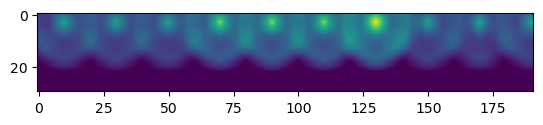

In [48]:
cc = cv.matchTemplate(txt_rgb, tmpl_rgb, cv.TM_CCORR_NORMED )
plt.imshow( cc );

Теперь поиск по шаблону сработал.
Посмотрим что он нашел.

In [49]:
dd = cc.flatten()
dd.sort()
dd

array([-1.5130935e-07, -1.4230703e-07, -1.3882710e-07, ...,
        8.7619030e-01,  8.7619042e-01,  1.0000000e+00], dtype=float32)

In [50]:
qq = cc == 1
np.count_nonzero( qq )

1

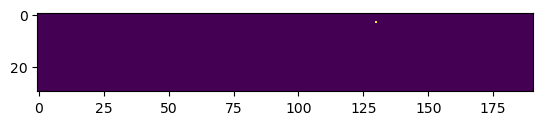

In [51]:
plt.imshow( qq, interpolation = 'none' );

In [52]:
pp = np.where( qq )

Серую букву О нашли.

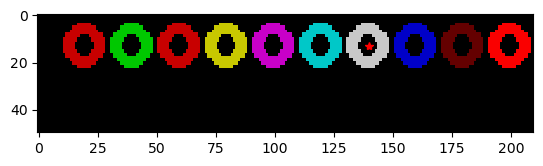

In [53]:
plt.imshow( txt_rgb, interpolation = 'none' );
plt.plot( pp[1]+10, pp[0]+10, "r*");

Видим, что нашли именно серую букву о. Это согласуется с тем, что используемый шаблон был как раз серым.

Сделаем шаблон красным. Для этого занулим две другие компоненты в сером шаблоне.

In [54]:
tmpl_rgb[:, :, 1] = np.zeros_like( tmpl ) # Зеленый.
tmpl_rgb[:, :, 2] = np.zeros_like( tmpl ) # Синий.

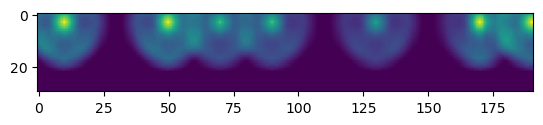

In [55]:
cc = cv.matchTemplate(txt_rgb, tmpl_rgb, cv.TM_CCORR_NORMED )
plt.imshow( cc );

In [56]:
dd = cc.flatten()
dd.sort()
dd

array([-2.9070338e-07, -2.8824763e-07, -2.7650105e-07, ...,
        1.0000000e+00,  1.0000000e+00,  1.0000000e+00], dtype=float32)

In [57]:
dd[-5:]

array([0.8761905, 1.       , 1.       , 1.       , 1.       ],
      dtype=float32)

Нашли четыре буквы О красного цвета.
У всех корреляция 1 внезависимости от яркости красного.

In [58]:
qq = cc == 1
np.count_nonzero( qq )

4

In [59]:
pp = np.where( qq )

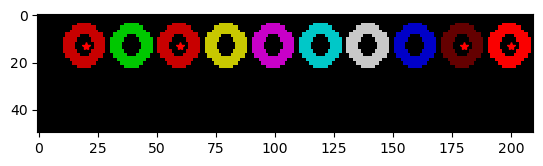

In [60]:
plt.imshow( txt_rgb, interpolation = 'none' );
plt.plot( pp[1]+10, pp[0]+10, "r*");

Все нужные, красного оттенка, буквы о нашлись.

<b>Цветные изображения</b>

Загрузим в качестве цветного изображения традиционно используемое в области цифровой обработке изображений.

In [61]:
img = cv.imread("./data/lena512color.tiff")[:,:,::-1]
img.shape, img.dtype

((512, 512, 3), dtype('uint8'))

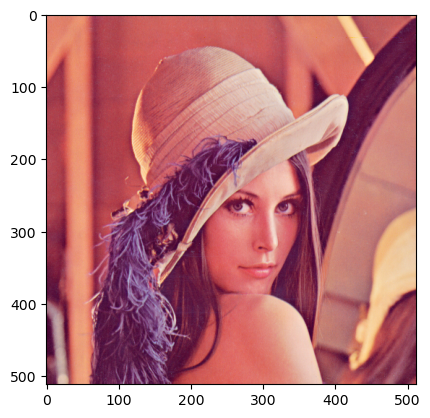

In [62]:
plt.imshow( img );

In [63]:
imgc = img.copy()

Напечатам что-то поверх цветного изображения. (например, букву "о")

In [64]:
cv.putText( imgc, 'o', 
    (250, 150), 
    font, fontScale,
    (200,200,200),# Используем серый цвет.
    lineType);

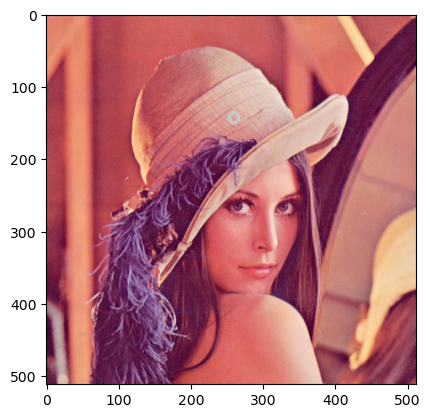

In [65]:
plt.imshow( imgc );

Всстановим серый шаблон для буквы о. Исходное изображение цветное, поэтому используем шаблон с тремя каналами

In [66]:
tmpl_rgb[:, :, 0] = tmpl
tmpl_rgb[:, :, 1] = tmpl
tmpl_rgb[:, :, 2] = tmpl

Будем использовать серый шаблон.

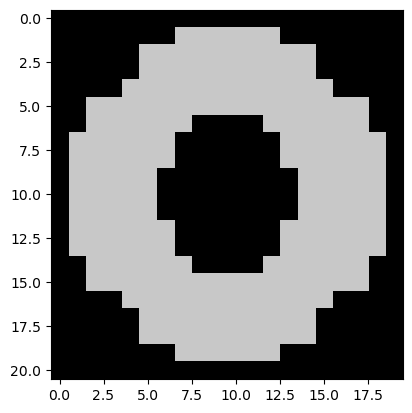

In [67]:
plt.imshow( tmpl_rgb );

In [68]:
np.max( tmpl )

200

In [69]:
cc = cv.matchTemplate( imgc, tmpl_rgb, cv.TM_CCORR_NORMED )
cc.shape

(492, 493)

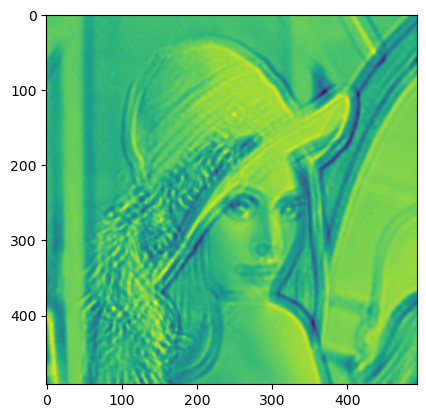

In [70]:
plt.imshow( cc );

In [71]:
W = np.where( cc>0.74 ) # Заметим какое незначительное пороговое значение.
W

(array([ 49, 114, 115, 116, 133, 383, 384, 384, 391, 391]),
 array([435, 400, 400, 400, 250, 145, 145, 146,  89,  90]))

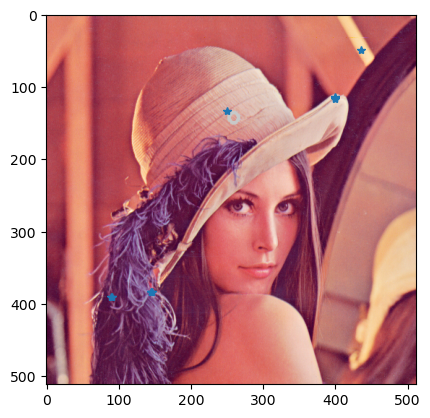

In [72]:
plt.imshow( imgc )
plt.plot( W[1], W[0], "*" );

В целом, да, нашли нужную букву о впридачу с другими точками.
Теперь сравним с методом поиска по образцу с маской.

In [73]:
tmpl_msk = tmpl.copy()
mask = np.zeros((tmpl_msk.shape[0]+2, tmpl_msk.shape[1]+2), np.uint8)
np.unique( tmpl_msk)

array([  0, 200], dtype=uint8)

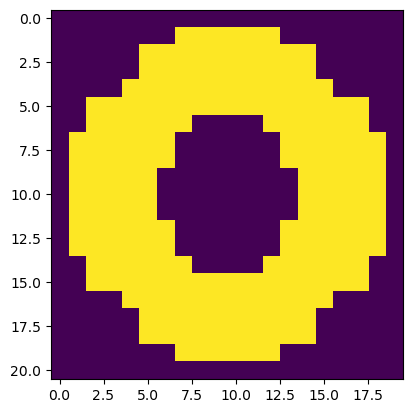

In [74]:
plt.imshow( tmpl_msk );

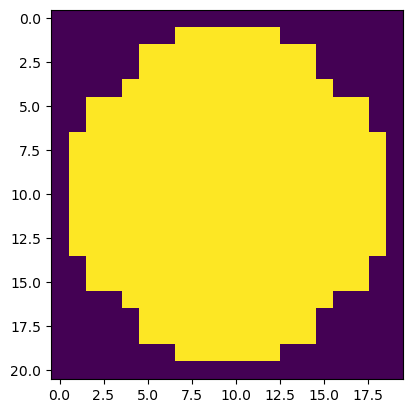

In [75]:
cv.floodFill( tmpl_msk, mask, (10,10), 200 )
plt.imshow( tmpl_msk );

Маской будет буква с заполненной внутренностью.

In [76]:
tmpl_msk.shape, tmpl_msk.dtype

((21, 20), dtype('uint8'))

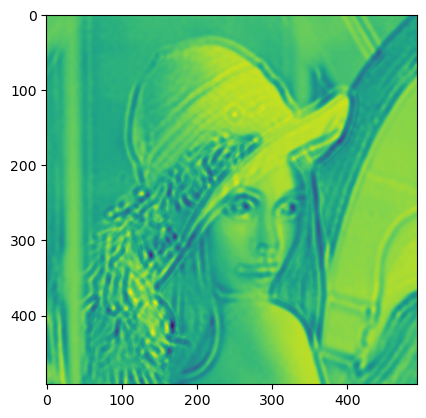

In [77]:
cc = cv.matchTemplate( imgc, tmpl_rgb, cv.TM_CCORR_NORMED, None, mask = tmpl_msk)
plt.imshow( cc );

In [78]:
# Занулим плохие числа.
cc[ ~np.isfinite(cc) ] = 0

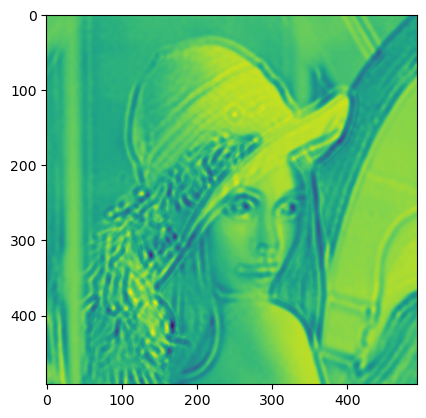

In [79]:
plt.imshow( cc );

In [80]:
W = np.where( cc>0.907 ) # Заметим насколько значемый порог теперь используется.
W

(array([133, 369, 369, 370, 383, 383, 384]),
 array([250, 111, 112, 112, 144, 145, 145]))

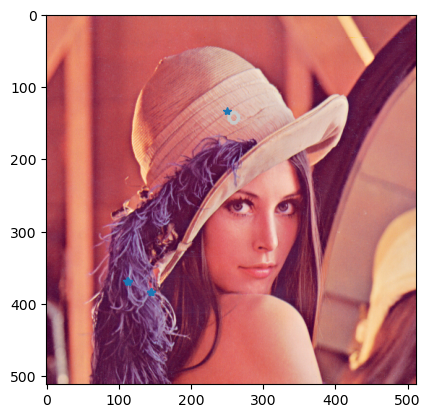

In [81]:
plt.imshow( imgc )
plt.plot( W[1], W[0], "*" );

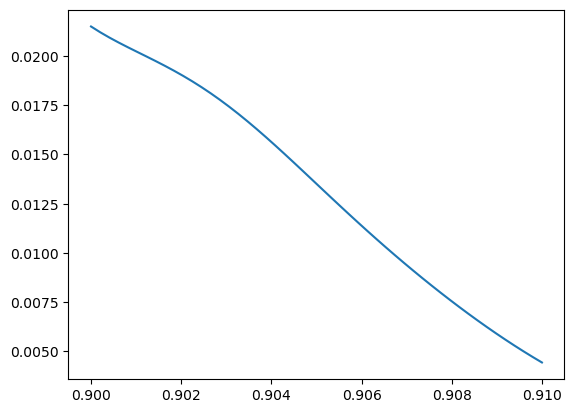

In [82]:
sm = stats.gaussian_kde( cc.flatten() )
val = np.linspace(0.9, 0.91, 50) # 0.9, 0.91
plt.plot( val, sm( val ) );

Увереность (значение пороговй функции) стала выше при использовании маски.

упр. Цветная буква.